# Urban Expansion and Its Impact on Biodiversity: A Study of BII Changes in Phoenix, Arizona

Author: Karol Paya

Github Repository: https://github.com/kpaya/impacts-of-urban-expansion-analysis

![Phoenix](data/Phoenix.jpg)
Source: [Kayak, 2024](https://www.kayak.com/Phoenix.18004.guide)

# Project Description

**Purpose:**

Maricopa County, home to the Phoenix metropolitan area, experienced the largest increase in developed land in the U.S. since 2001 [(Washington Post, 2021)](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). This rapid urban sprawl poses significant challenges to local biodiversity and the integrity of natural ecosystems. This notebook will examine the changes in Biodiversity Intactness Index (BII) within the Phoenix county subdivision area between 2017 and 2020, providing insights into how urban growth has influenced biodiversity over time.

**Highlights:**

This notebook contains two reusable functions, biodiversity_function and percent_function, which significantly streamline the analysis workflow. By automating data wrangling and key calculations such as the Biodiversity Intactness Index (BII) and percentage change, these functions ensure consistency and efficiency throughout the process.

Addionationally, visualizations with maps were created to illustrate the change in BII, helping to identify areas of significant change due to urbanization. The color-coded maps provide an intuitive understanding of where biodiversity has been most impacted by development, highlighting area where conservation efforts may be needed.

**About the Data:**

In order to perform the BII analysis, two datasets were used:

The Biodiversity Intactness Index was sourced from the Microsoft Planerty Computer platform. These datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline [(Microsoft Planetary Computer, 2024)](https://planetarycomputer.microsoft.com/dataset/io-biodiversity).

The Tiger/Line shapefile was obtained from the US Census Bureau. It provides the legal boundaries of all US cities.

A base map from OpenStreetMap was used to provide contextual geographic information for visualizations.

**References:**

Microsoft Planetary Computer. Biodiversity Intactness. 2024. Microsoft. Retrieved December 5, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

Census Bureau, TIGER/Line Shapefiles. 2024. Census.Gov. Retrieved December 5, 2024, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

OpenStreetMap contributors. BaseMap. 2024. OpenStreetMap. Retrieved December 5, 2024, from https://www.openstreetmap.org/copyright

# Import libraries

In [187]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client  
import planetary_computer  
from IPython.display import Image
from shapely import box
from pyproj import CRS
import xarray as xr
from tabulate import tabulate
import contextily as ctx

# Load Data

In [3]:
# Load boundary shapefile
state= gpd.read_file(os.path.join('data','tl_2020_04_cousub.shp'))

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

catalog.get_collections()

# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# Define the bounding box coordinates for Maricopa County, AZ
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 32.974108],  # Bottom-left corner
            [-112.826843, 33.863574],  # Top-left corner
            [-111.184387, 33.863574],  # Top-right corner
            [-111.184387, 32.974108],  # Bottom-right corner
            [-112.826843, 32.974108]   # Back to bottom-left corner
        ]
    ],
}

# Catalog search
search = catalog.search(
    collections = ["io-biodiversity"], # speficy biodiversity collection
    intersects = bbox,
    datetime = time_range)

# Data Exploration

## Phoenix Subdivision Boundary

In [4]:
# Display the first few rows of the DataFrame to get an overview of the data
state.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."


In [5]:
# Check coordinate reference system
state.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

The boundary shapefile includes the legal boundaries of all states. To focus our analysis on the area of interest, we will filter the dataset to isolate the city's boundary. The shapefile uses the EPSG:4269 coordinate reference system, which is a geographic coordinate system based on the NAD83 datum.

## Biodiversity Intactness Index

In [6]:
# Retrieve search items
items = search.item_collection()

# Examine the feature collection, use first item
item = items[0]
item

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [7]:
# Check the type
type(item)

pystac.item.Item

In [8]:
# Plot a preview of the map
Image(url=item.assets['rendered_preview'].href, width=500)

In [9]:
# Print Geometry
print("Type of Geometry:", (item.geometry))

Type of Geometry: {'type': 'Polygon', 'coordinates': [[[-114.7625474, 27.565314], [-108.2066425, 27.565314], [-108.2066425, 34.7446497], [-115.3859782, 34.7446497], [-115.3859782, 29.5649638], [-115.3581305, 28.0791503], [-115.2036202, 27.8662496], [-114.9988044, 27.7099428], [-114.7625474, 27.565314]]]}


In [10]:
# Print properties
print("Properities: ", (item.properties))

Properities:  {'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2020-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2020-01-01T00:00:00Z'}


In [11]:
# Verify a metric CRS for area of interest
# Check CRS for Arizona (EPSG:26913)
crs_utm_13n = CRS.from_epsg(26913)

# Verify the unit of measurement (meters)
print(f"Units for UTM Zone 13N: {crs_utm_13n.axis_info[0].unit_name}")

Units for UTM Zone 13N: metre


Based on the assessment above, the BII dataset type is STAC (SpatioTemporal Asset Catalog) containing polygon features. We have acknowledged that the current CRS (EPSG:4326, WGS 84) is a geographic coordinate system that uses degrees as units, which is unsuitable for performing area calculations. Since area calculations require a projected coordinate system with units in meters, we will reproject the data to an appropriate metric-based CRS - EPSG:26913.

Additionally, the analysis revealed that the indexes contains an unnecessary extra dimension (band) along with x and y coordinates. This dimension, which does not contribute to the analysis, will be removed to simplify the data structure.

## Data Analysis

The following section contains two functions to perform the analysis:

`biodiversity_function`: This function retrieves and processes biodiversity raster data for a specified city and year. It selects the appropriate dataset, removes unnecessary dimensions, and reprojects both the biodiversity raster and city boundary to ensure they share the same coordinate reference system (CRS). The function then clips the raster to the city’s boundary and returns the clipped raster along with the city polygon.

Inputs:

`year` (int): The year for the data (e.g., 2018)

`city` (string): The city of interest (e.g., 'Phoenix')


`percent_function`: This function calculates the percentage of the clipped raster area that has a Biodiversity Intactness Index (BII) above a selected threshold. It reprojects the raster, counts the pixels meeting the threshold, and computes the total area and percentage of the city covered by these pixels. The function returns both the percentage and a filtered raster, where pixels meeting the threshold are marked as 1.

Inputs:

`biodiversity` (xarray): Output from `biodiversity_function`[0]

`year` (int): The year for the analysis (e.g., 2018)

`threshold` (int): The BII threshold (e.g., 0.75)


## Creating Functions

In [12]:
def biodiversity_function(year, city):
    # Define year_dict
    year_dict = {
        2020: 0,
        2019: 1,
        2018: 2,
        2017: 3
    }
    
    # Retrieve search items
    items = search.item_collection()
    
    # Get the item for assigned year
    item = items[year_dict[year]]
    
    # Open biodiversity data from the catalog
    biodiversity = rioxr.open_rasterio(item.assets['data'].href)

    # Remove length 1 dimension (band)
    biodiversity = biodiversity.squeeze().drop_vars('band')

    # Create GeoDataFrame from raster bounding box
    biodiversity_bbox = gpd.GeoDataFrame(geometry=[box(*biodiversity.rio.bounds())], crs=biodiversity.rio.crs)
    
    # Filter the city area based on city name
    city_area = state[state['NAME'] == city]

    # Reproject the biodiversity bounding box and city area to match each other's CRS
    biodiversity_bbox = biodiversity_bbox.to_crs(city_area.crs)
    city_area_match = city_area.to_crs(biodiversity.rio.crs)
    
    # Ensure CRS match
    assert city_area_match.crs == biodiversity.rio.crs

    # Print original no-data value of the raster
    print(f'{year} Original no-data value: ', biodiversity.rio.nodata)

    # Update the raster's no-data value to 0
    biodiversity = biodiversity.rio.write_nodata(0)
    print(f'{year} Updated no-data value: ', biodiversity.rio.nodata)

    # Clip the raster by the city area
    biodiversity_clip = (biodiversity.rio.clip_box(*city_area_match.total_bounds)
                         .rio.clip(city_area_match.geometry))

    # Return the the clipped biodiversity_clip and the city polygon
    return biodiversity_clip, city_area

In [50]:
def percent_function(biodiversity, year, threshold):
    
    # Retrieve output from biodiversity_function
    biodiversity_clip=biodiversity[0]
    phoenix_area=biodiversity[1]
    
    # Reproject biodiversity_clip to a metric CRS
    biodiversity_clip_26913 = biodiversity_clip.rio.reproject("EPSG:26913") 
    
    print(f"{year} Resolution (metric): {biodiversity_clip_26913.rio.resolution()}")

    #return_counts: If True, also return the number of times each unique item appears in ar
    pixel_values, pixel_counts = np.unique(biodiversity_clip_26913.values, return_counts=True)

    # Create dataframe that includes values and counts of each pixel
    pixel_df = pd.DataFrame({
        'pixel_value': pixel_values,
        'pixel_count': pixel_counts
    })

    # Compute the total count of pixels in Phoenix subdivision
    total_pixels=sum(pixel_df['pixel_count'])

    # Apply the condition to filter pixel values >= threshold
    pixel_df_threshold = pixel_df[pixel_df['pixel_value'] >= threshold]

    # Calculate Pixel Area
    # 1 km² = 1,000,000 m²
    pixel_area = (abs(biodiversity_clip_26913.rio.resolution()[0]) * abs(biodiversity_clip_26913.rio.resolution()[1]))/1000000

    # Compute total area covered
    total_pixels_threshold=sum(pixel_df_threshold['pixel_count'])
    total_area_threshold = total_pixels_threshold * pixel_area

    # Calculate the percentage of area of the Phoenix subdivision with a BII threshold
    percent= ((total_pixels_threshold * pixel_area)/(total_pixels* pixel_area))*100
    
    # Apply condition: pixel value >= threshold
    filtered_raster = xr.DataArray(np.where(biodiversity_clip >= threshold, 1, 0))   
    
    # Create a summary table
    summary_data = {
        'Year': [year],
        'Total Pixels': [total_pixels],
        'Area of 1 Pixel': [pixel_area],
        'Total Pixels >threshold': [total_pixels_threshold],
        'Total Area(km2)': [total_area_threshold], 
        'Percent Area(%)': [percent]
    }

    summary_df = pd.DataFrame(summary_data)
    

    # Return total percent and the df with BII >= threshold
    return percent,filtered_raster, summary_df

## Perform Analysis

In [51]:
# Define 2017 and 2020 inputs to function
city='Phoenix'
threshold=0.75

# Run functions for 2017
biodiversity_2017 = biodiversity_function(2017,city)
percent_2017 = percent_function(biodiversity_2017, 2017,threshold)

# Run functions for 2020
biodiversity_2020 = biodiversity_function(2020,city)
percent_2020 = percent_function(biodiversity_2020, 2020,threshold)

2017 Original no-data value:  None
2017 Updated no-data value:  0.0
2017 Resolution: (88.31128751748638, -88.31128751748638)
2020 Original no-data value:  None
2020 Updated no-data value:  0.0
2020 Resolution: (88.31128751748638, -88.31128751748638)


In [190]:
# Merging the two DataFrames
merged_df = pd.concat([percent_2017[2], percent_2020[2]], axis=0, ignore_index=True).round(2)

# Print summary table for the two years
print("Table 1: Summary of Percent Area with BII Greater than 0.75")
print(tabulate(merged_df, headers='keys', tablefmt='fancy_grid', showindex=False))

Table 1: Summary of Percent Area with BII Greater than 0.75
╒════════╤════════════════╤═══════════════════╤═══════════════════════════╤═══════════════════╤═══════════════════╕
│   Year │   Total Pixels │   Area of 1 Pixel │   Total Pixels >threshold │   Total Area(km2) │   Percent Area(%) │
╞════════╪════════════════╪═══════════════════╪═══════════════════════════╪═══════════════════╪═══════════════════╡
│   2017 │         709986 │              0.01 │                     25907 │            202.05 │              3.65 │
├────────┼────────────────┼───────────────────┼───────────────────────────┼───────────────────┼───────────────────┤
│   2020 │         709986 │              0.01 │                     23621 │            184.22 │              3.33 │
╘════════╧════════════════╧═══════════════════╧═══════════════════════════╧═══════════════════╧═══════════════════╛


As shown in Table 1, the percentage of the Phoenix subdivision area with a Biodiversity Intactness Index (BII) of at least 0.75 has decreased from 3.65% in 2017 to 3.33% in 2020. This represents a decline of 0.32%, indicating a slight reduction in areas with high biodiversity intactness over the period. This change suggests that urbanization or other factors may have contributed to the loss of areas with high BII in the region.

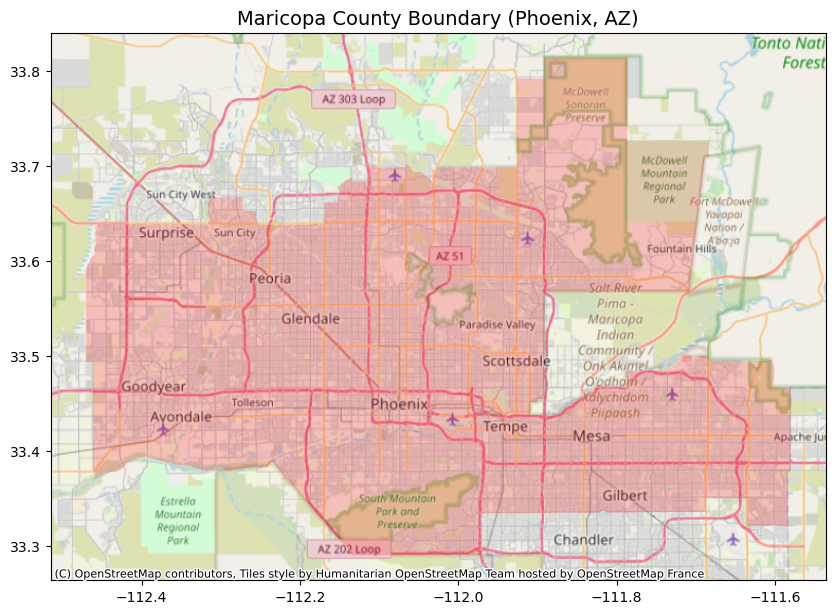

In [189]:
# Phoenix subdivision map

# Extract the Phoenix boundary
city_map = biodiversity_2020[1]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Phoenix subdivision boundary
city_map.plot(ax=ax,alpha=0.2, color="red")

# Add base map from contextily
ctx.add_basemap(ax, crs=city_map.crs.to_string())

# Customize the plot
ax.set_title("Maricopa County Boundary (Phoenix, AZ)", fontsize=14)

# Show the plot
plt.show()

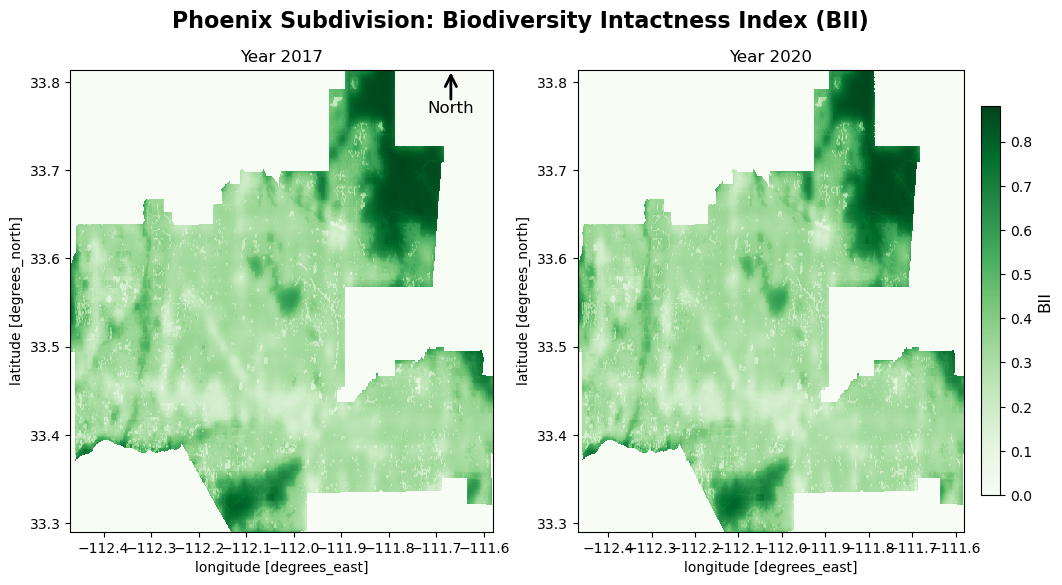

In [80]:
# Create two maps to compare 2017 - 2020 BII
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the 2017 BII map
biodiversity_2017[0].plot(ax=axes[0], cmap='Greens', add_colorbar=False)
axes[0].set_title("Year 2017")

# Plot the 2020 BII map
map_2020=biodiversity_2020[0].plot(ax=axes[1], cmap='Greens', add_colorbar=False)
axes[1].set_title("Year 2020")

# Add colorbar
cbar = fig.colorbar(map_2020, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label("BII", fontsize=12)

# Add North arrow
arrow = FancyArrowPatch(
    (0.9, 0.93), (0.9, 1), 
    mutation_scale=20, 
    color='black', 
    lw=2, 
    arrowstyle='->', 
    label='North', 
    transform=axes[0].transAxes)

axes[0].add_patch(arrow)
axes[0].text(0.9, 0.9, 'North', color='black', fontsize=12, ha='center', va='bottom', transform=axes[0].transAxes)

# Add title 
fig.suptitle("Phoenix Subdivision: Biodiversity Intactness Index (BII)", fontsize=16, fontweight='bold')

# Show the plots
plt.show()

Based on the visualization above, it is difficult to distinguish the changes in the BII between 2017 and 2020. We will conduct further analysis to better understand the loss of areas with a BII greater than 0.75.

In [81]:
# Find which pixels have changed its value 
# Calculate the difference between the two years
diff=percent_2017[1]-percent_2020[1]

# Filter values that have a value of 1
diff_filtered = diff.where(diff == 1)

# Reproject the raster
diff_filtered_reprojected = diff_filtered.rio.write_crs(biodiversity_2017[1].crs)

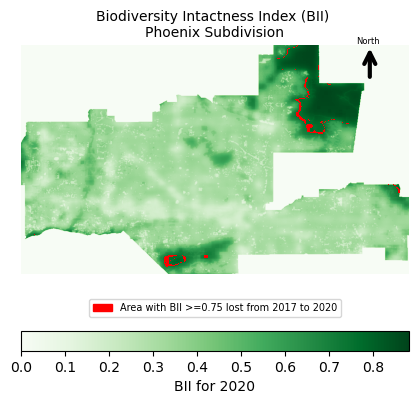

In [193]:
# Create map
fig, ax = plt.subplots(figsize=(5, 5))

# Remove axis
ax.axis('off')

# Plot the biodiversity map
background_plot=ax.imshow(biodiversity_2020[0], cmap='Greens')
background_plot

# Create a custom colormap: Only show 1 as red, others will be transparent (NaN)
cmap = mcolors.ListedColormap([ 'red'])  # Red for 1, transparent for NaN
bounds = [0, 1]  # Values between 0 and 1 are masked out (transparent), 1 will be red
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the difference filtered dataset
diff_filtered_reprojected.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create a custom legend for the difference map (change in BII)
red_patch = mpatches.Patch(color='red', label="Area with BII >=0.75 lost from 2017 to 2020")

# Add the custom legend for the BII lost
ax.legend(handles=[red_patch], loc='center', fontsize=7, bbox_to_anchor=(0.5, -0.15))

# Add a colorbar
plt.colorbar(background_plot, ax=ax, orientation='horizontal', label="BII for 2020")

# Add a title
ax.set_title("Biodiversity Intactness Index (BII) \nPhoenix Subdivision", fontsize=10)

# Reverse the y-axis
ax.invert_yaxis()

# Add North arrow
arrow = FancyArrowPatch(
    (0.9, 0.85), (0.9, 1), 
    mutation_scale=20, 
    color='black', 
    lw=3, 
    arrowstyle='->', 
    label='North', 
    transform=ax.transAxes)

ax.add_patch(arrow)
ax.text(0.925, 1, 'North', color='black', fontsize=6, ha='right', va='bottom', transform=ax.transAxes)

# Show plot
plt.show()

This project analysis reveals a 0.32% decline in the Biodiversity Intactness Index (BII) where the index is greater than 0.75. The affected areas are depicted in the map above. Notably, these losses are occurring within protected areas, such as the South Mountain & Park Preserve and McDowell Mountain Regional Park. This trend suggests that urban expansion, especially residential development, is increasingly posing a significant threat to local biodiversity.